# Temperature and flow solutions

In [1]:
%load_ext autoreload
%autoreload 2
%run ct_data.py '../crunchtope_model/results.nc' -c pH totcon
%run pf_data.py '../pflotran_model/flow_steady_state/steady_flow.h5'
%run figures.py
import cmcrameri.cm as cm

Error: The following variables are not in the xarray object: ['Forsterite_VF', 'Fayalite_VF']. Mineral not found.
Assuming flow only simulation, data available.


In [2]:
pf_data

<xarray.Dataset> Size: 4MB
Dimensions:            (time: 41, x: 32, y: 1, z: 32)
Coordinates:
  * time               (time) float64 328B 0.0 500.0 1e+03 ... 1.95e+04 2e+04
  * x                  (x) float64 256B 23.44 70.31 117.2 ... 1.43e+03 1.477e+03
  * y                  (y) float64 8B 50.0
  * z                  (z) float64 256B 23.44 70.31 117.2 ... 1.43e+03 1.477e+03
Data variables:
    Liquid X-Velocity  (time, x, y, z) float64 336kB 0.0 0.0 ... -0.0002561
    Liquid Y-Velocity  (time, x, y, z) float64 336kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Liquid Z-Velocity  (time, x, y, z) float64 336kB 0.0 0.0 ... -0.07982
    Liquid_Density     (time, x, y, z) float64 336kB 930.3 930.1 ... 1.049e+03
    Liquid_Pressure    (time, x, y, z) float64 336kB 1.134e+08 ... 1.002e+08
    Liquid_Saturation  (time, x, y, z) float64 336kB 1.0 1.0 1.0 ... 1.0 1.0 1.0
    Liquid_Viscosity   (time, x, y, z) float64 336kB 9.303e-05 ... 0.001592
    Material_ID        (time, x, y, z) int32 168kB 1 1 1 1 1 1 1 ... 2 2 2 2 2 2
    Mineral_Porosity   (time, x, y, z) float64 336kB 0.01 0.01 ... 0.01 0.01
    Permeability       (time, x, y, z) float64 336kB 2e-15 2e-15 ... 2e-13 2e-13
    Temperature        (time, x, y, z) float64 336kB 400.0 400.0 ... 2.153 2.042

Text(0, 0.5, 'Z / m')

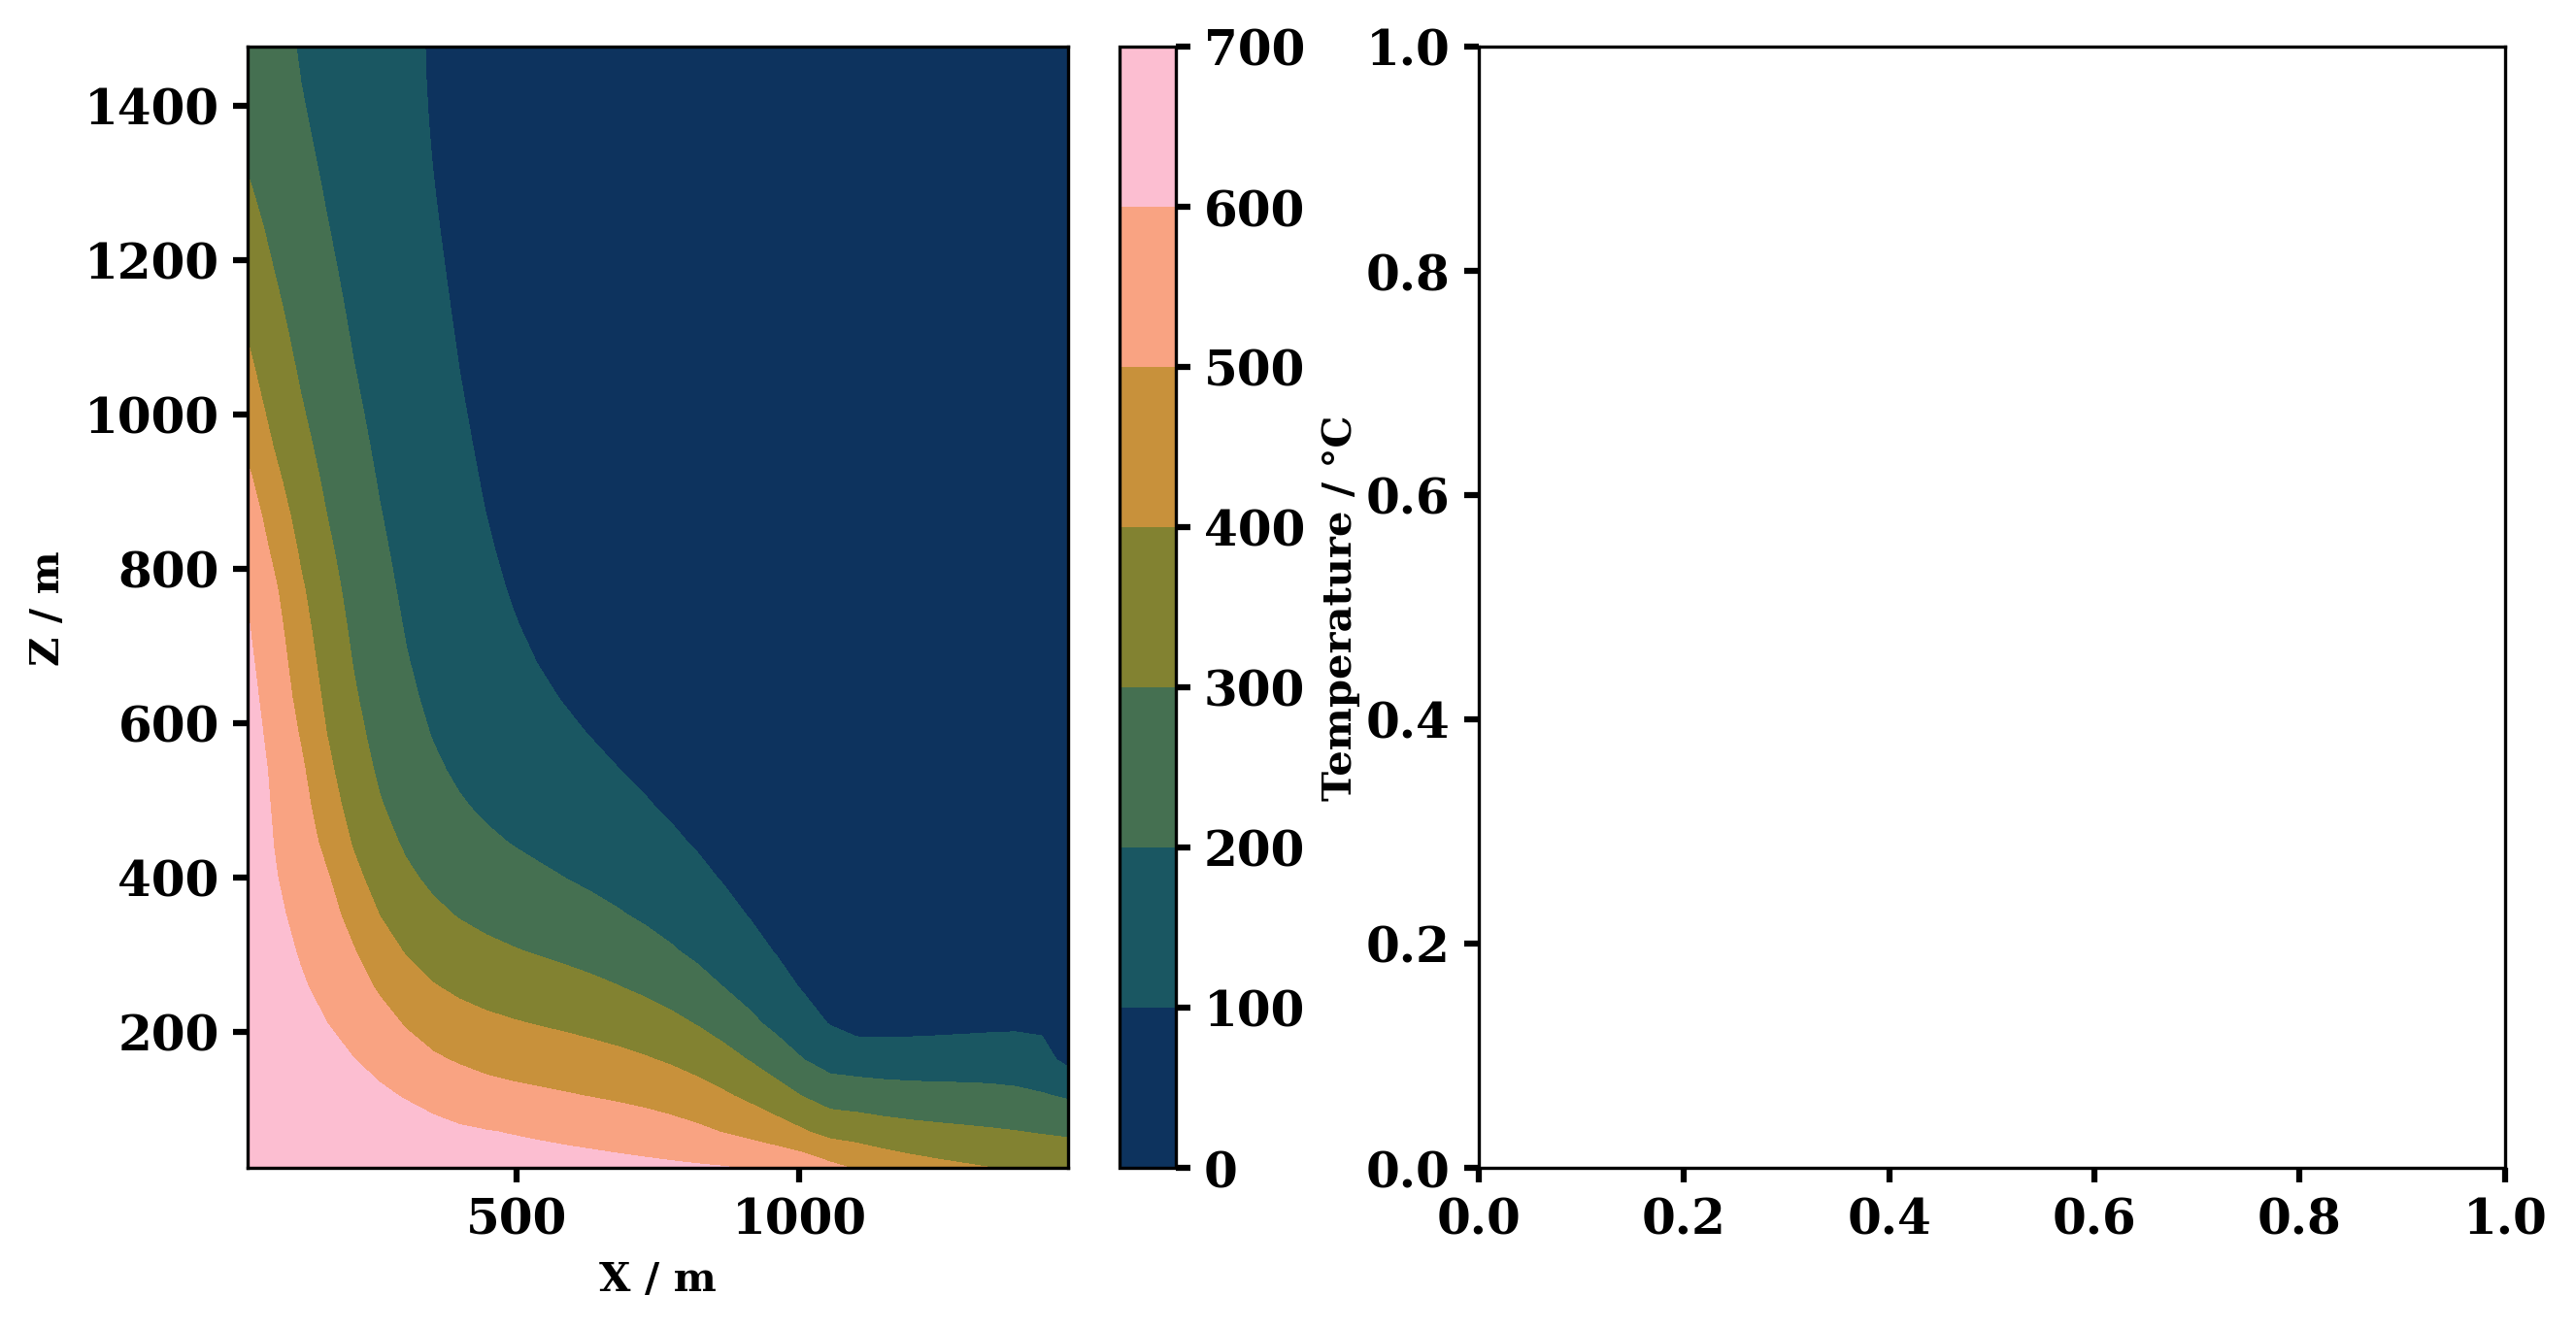

In [3]:
import matplotlib.pyplot as plt
plt.style.use('custom.mplstyle')
import xarray as xr

ds = pf_data

# Assuming 'ds' is your xarray dataset and 'temperature' is the variable of interest
# Replace 'ds' with the actual dataset name
temperature = ds.Temperature.isel(y=0, time=-1)

# Extract X and Z spatial coordinates
x = ds.coords['x']  # Replace 'X' with actual x-coordinate name if different
z = ds.coords['z']  # Replace 'Z' with actual z-coordinate name if different

# Create the contour plot
fig, ax = plt.subplots(1,2, figsize=(10, 5))
contour = ax[0].contourf(x, z, temperature, cmap=cm.batlow)

# Add color bar for temperature
fig.colorbar(contour, label='Temperature / °C')

# Label axes
ax[0].set_xlabel('X / m')
ax[0].set_ylabel('Z / m')

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Select the velocity slices at y=0 and for the nearest time step at time=1000
x_velocity_slice = ds['Liquid X-Velocity'].isel(y=0).sel(time=1000, method='nearest').values
z_velocity_slice = ds['Liquid Z-Velocity'].isel(y=0).sel(time=1000, method='nearest').values

speed = np.sqrt(x_velocity_slice**2 + z_velocity_slice**2)

# Extract X and Z coordinates
x = ds.coords['x'].values  # 1D X array
z = ds.coords['z'].values  # 1D Z array

x_velocity_slice = x_velocity_slice.T  # Transpose to match (Z, X)
z_velocity_slice = z_velocity_slice.T  # Transpose to match (Z, X)
permeability = np.log10(pf_data['Permeability'].isel(y=0).sel(time=1000, method='nearest').values.T)

# Create meshgrid from X and Z coordinates
X, Z = np.meshgrid(x, z)

# Create the stream plot for X and Z velocities
strm = ax[1].streamplot(X, Z, u=x_velocity_slice, v=z_velocity_slice, density=1, maxlength=10000000, integration_direction='backward', start_points=[[30,1450]], color='w', linewidth=0.5, arrowsize=1, arrowstyle='->')

from matplotlib.colors import BoundaryNorm
cmap = plt.get_cmap('viridis')
levels = [-15.69897, -14.69897, -13.69897, -12.69897]
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

# Use pcolormesh for sharp, blocky rendering
cmap = plt.get_cmap(cm.batlow)
norm = plt.Normalize(vmin=min(levels), vmax=max(levels))

# Plot with pcolormesh
mesh = ax[1].pcolormesh(X, Z, permeability, cmap=cmap, norm=norm)

# Label the axesaa
ax[1].set_xlabel('X / m')
ax[1].set_ylabel('Z / m')
cbar = fig.colorbar(mesh, label = 'Permeability / log10(m$^2$)')

# Adjust layout and save the figure
fig.tight_layout()
fig.savefig('output/figure_s2.png', dpi=300)

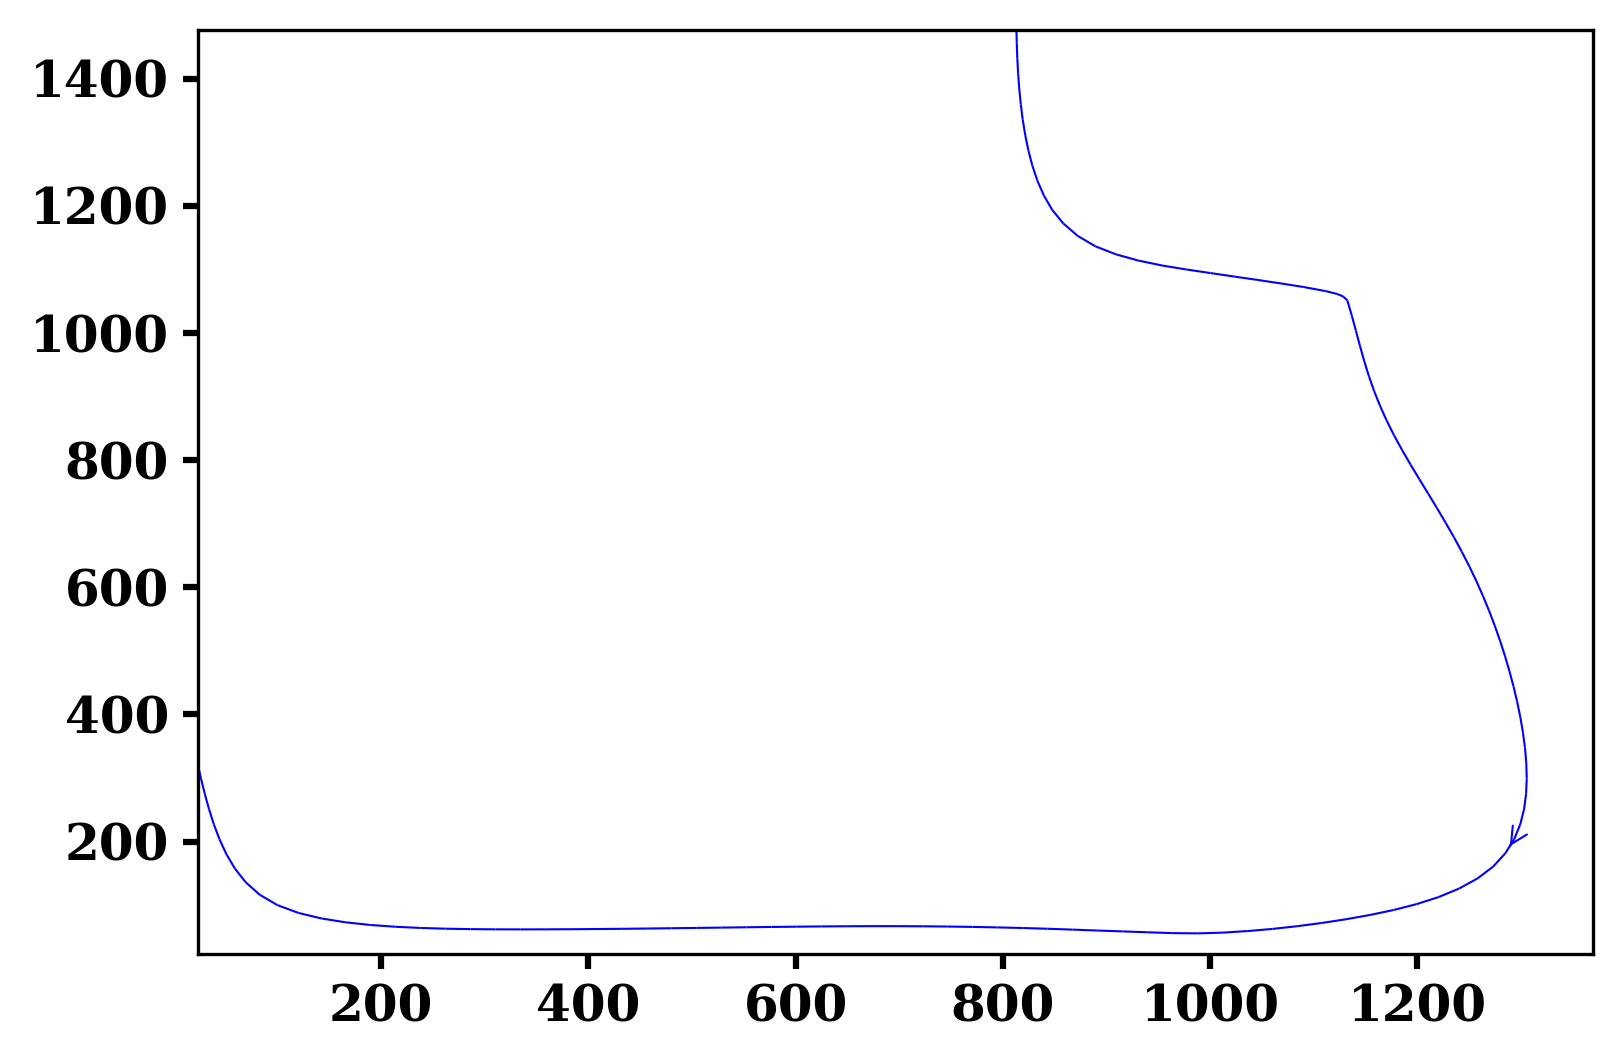

Total length of the streamline: 2982.78 units


35.96058924743464

In [6]:
# Function to calculate the average speed along a streamline
def average_speed_along_streamline(streamline_data):
    # Get the coordinates and velocities along the first streamline
    U = x_velocity_slice
    V = z_velocity_slice
    y=z
    
    x_coords = []
    y_coords = []
    # Extract x, y coordinates from the streamline
    for path in streamline_data.lines.get_paths():
        x_coords.append(path.vertices[0, 0])
        y_coords.append(path.vertices[0, 1])

    # Interpolate the velocity (U, V) and speed at these points
    interpolated_speeds = []
    for (x_val, y_val) in zip(x_coords, y_coords):
        u_val = np.interp(x_val, x, U[:, np.argmin(np.abs(y - y_val))])
        v_val = np.interp(y_val, y, V[np.argmin(np.abs(x - x_val)), :])
        interpolated_speeds.append(np.sqrt(u_val**2 + v_val**2))

    # Calculate the average speed along the streamline
    avg_speed = np.mean(interpolated_speeds) / 0.01
    return avg_speed

# Function to calculate the length of a streamline
def streamline_length(streamline_data):
    total_length = 0  # Initialize total length to 0

    # Loop through each streamline in the streamline data
    for path in streamline_data.lines.get_paths():
        # Extract x, y coordinates from the streamline vertices
        x_coords = path.vertices[:, 0]
        y_coords = path.vertices[:, 1]

        # Loop through the vertices and calculate the distance between consecutive points
        for i in range(1, len(x_coords)):
            x1, y1 = x_coords[i - 1], y_coords[i - 1]
            x2, y2 = x_coords[i], y_coords[i]

            # Calculate the distance between the two points
            distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

            # Add the distance to the total length
            total_length += distance

    return total_length

strm = plt.streamplot(X, Z, u=x_velocity_slice, v=z_velocity_slice, density=2, start_points=[[100,100]], color='b', linewidth=0.5, arrowsize=1, arrowstyle='->')

plt.show()
# Example usage: calculate the length of streamlines from the streamplot result
streamline_data = strm  # This is your streamline data from plt.streamplot
length = streamline_length(streamline_data)
print(f"Total length of the streamline: {length:.2f} units")


average_speed_along_streamline(strm)